# Librerías

In [2]:
import pandas as pd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
from pmdarima import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from skforecast.ForecasterSarimax import ForecasterSarimax
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from sklearn.feature_selection import RFECV
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.model_selection import bayesian_search_forecaster
from skforecast.model_selection import backtesting_forecaster
from skforecast.model_selection_sarimax import backtesting_sarimax
import warnings
warnings.filterwarnings('ignore')

# ENTRENAMIENTO DE MODELOS

## Carga de datos

In [3]:
df = pd.read_csv("datos_preprocesados.csv", parse_dates=['fecha'], index_col='fecha')
df = df.asfreq('D')
df = df.sort_index()

## División del conjunto de datos

In [5]:
# Divisiones de los datos en los conjuntos de entrenamiento y test
end_train = '2023-08-05'

data_train = df.loc[:end_train]
data_test  = df.loc[end_train:]

print(f"Dates train      : {data_train.index.min()} --- {data_train.index.max()}  (n={len(data_train)})")
print(f"Dates test       : {data_test.index.min()} --- {data_test.index.max()}  (n={len(data_test)})")

Dates train      : 2019-01-01 00:00:00 --- 2023-08-05 00:00:00  (n=1678)
Dates test       : 2023-08-05 00:00:00 --- 2024-09-26 00:00:00  (n=419)


## Función para un modelo genérico con variables exógenas

In [6]:
def generic_model(modelo, df, lags, exog_features, search_space, n_iter):

    if modelo == 'decision_tree':
        forecaster = ForecasterAutoreg(regressor = DecisionTreeRegressor(random_state=15926), lags = lags)

    if modelo == 'random_forest':
        forecaster = ForecasterAutoreg(regressor = RandomForestRegressor(random_state=151226), lags = lags)

    if modelo == 'xgboost':
        forecaster = ForecasterAutoreg(regressor = XGBRegressor(random_state=15942), lags = lags)
    

    results_search, frozen_trial = bayesian_search_forecaster(
    forecaster         = forecaster,
    y                  = df['demanda'],
    exog               = df[exog_features],
    search_space       = search_space,
    steps              = 1,
    refit              = False,
    metric             = 'mean_absolute_error',
    initial_train_size = len(data_train),
    fixed_train_size   = False,
    n_trials           = n_iter,
    random_state       = 123,
    return_best        = True,
    n_jobs             = 'auto',
    verbose            = False,
    show_progress      = False
    )
    
    best_params = results_search['params'].iat[0]

    metric, predictions = backtesting_forecaster(
    forecaster         = forecaster,
    y                  = df['demanda'],
    exog               = df[exog_features],
    steps              = 1,
    metric             = 'mean_absolute_error',
    initial_train_size = len(data_train),
    refit              = False,
    n_jobs             = 'auto',
    verbose            = False,
    show_progress      = False
    )

    return predictions, best_params, metric.iloc[0]

## Resultados de modelo Decision Tree

In [7]:
modelo = 'decision_tree'

exog_features = ['diasem', 'trim', 'festivo', 'tmed']

lags = 7

def search_space(trial):
    search_space = {
        'max_depth'             : trial.suggest_int('max_depth', 3, 20, step=1),                  # Profundidad máxima del árbol
        'max_leaf_nodes'        : trial.suggest_int('max_leaf_nodes', 30, 70, step=1),            # Máximo número de hojas en el árbol
        'min_samples_leaf'      : trial.suggest_int('min_samples_leaf', 1, 10, step=1),          # Mínimo de muestras por hoja
        'min_samples_split'     : trial.suggest_int('min_samples_split', 2, 20, step=1),         # Mínimo de muestras para dividir un nodo
    }
    return search_space

n_iter = 200

In [8]:
start_time = time.time()

resultado = generic_model(modelo, df, 7, exog_features, search_space, n_iter)

end_time = time.time() - start_time

print(f'PARA EL MODELO {modelo}')
print(f'VARIABLES EXOGENAS: {exog_features}')
print(f'Tiempo de ejecución: {end_time:.2f} segundos')
print(f'{resultado[2]}')
print(f'HIPERPARAMETROS: {resultado[1]}')

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [1 2 3 4 5 6 7] 
  Parameters: {'max_depth': 11, 'max_leaf_nodes': 53, 'min_samples_leaf': 4, 'min_samples_split': 17}
  Backtesting metric: 790.5329867435235

PARA EL MODELO decision_tree
VARIABLES EXOGENAS: ['diasem', 'trim', 'festivo', 'tmed']
Tiempo de ejecución: 153.65 segundos
mean_absolute_error    790.532987
Name: 0, dtype: float64
HIPERPARAMETROS: {'max_depth': 11, 'max_leaf_nodes': 53, 'min_samples_leaf': 4, 'min_samples_split': 17}


## Resultados de modelo Random Forest

In [11]:
modelo = 'random_forest'

exog_features = ['diasem', 'trim', 'festivo', 'tmed', 'hrmed']

lags = 7

def search_space(trial):
    search_space = {
        'n_estimators'          : trial.suggest_int('n_estimators', 50, 200, step=10),
        'max_depth'             : trial.suggest_int('max_depth', 3, 20, step=1),                  # Profundidad máxima del árbol
        'max_leaf_nodes'        : trial.suggest_int('max_leaf_nodes', 30, 70, step=1),            # Máximo número de hojas en el árbol
        'min_samples_leaf'      : trial.suggest_int('min_samples_leaf', 1, 10, step=1),          # Mínimo de muestras por hoja
        'min_samples_split'     : trial.suggest_int('min_samples_split', 2, 20, step=1),         # Mínimo de muestras para dividir un nodo
        'max_samples'           : trial.suggest_float('max_samples', 0.5, 1.0)
    }
    return search_space

n_iter = 200

In [12]:
start_time = time.time()

resultado = generic_model(modelo, df, lags, exog_features, search_space, n_iter)

end_time = time.time() - start_time

print(f'PARA EL MODELO {modelo}')
print(f'VARIABLES EXOGENAS: {exog_features}')
print(f'Tiempo de ejecución: {end_time:.2f} segundos')
print(f'{resultado[2]}')
print(f'HIPERPARAMETROS: {resultado[1]}')

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [1 2 3 4 5 6 7] 
  Parameters: {'n_estimators': 130, 'max_depth': 18, 'max_leaf_nodes': 67, 'min_samples_leaf': 2, 'min_samples_split': 19, 'max_samples': 0.6370636467556214}
  Backtesting metric: 641.0780114320438

PARA EL MODELO random_forest
VARIABLES EXOGENAS: ['diasem', 'trim', 'festivo', 'tmed', 'hrmed']
Tiempo de ejecución: 668.72 segundos
mean_absolute_error    641.078011
Name: 0, dtype: float64
HIPERPARAMETROS: {'n_estimators': 130, 'max_depth': 18, 'max_leaf_nodes': 67, 'min_samples_leaf': 2, 'min_samples_split': 19, 'max_samples': 0.6370636467556214}


## Resultados de modelo XGBoost

In [14]:
modelo = 'xgboost'

exog_features = ['diasem', 'trim', 'festivo', 'tmed', 'hrmed']

lags = 7

def search_space(trial):
    search_space  = {
        'n_estimators'    : trial.suggest_int('n_estimators', 200, 400, step=10),
        'max_depth'       : trial.suggest_int('max_depth', 3, 10, step=1),
        'learning_rate'   : trial.suggest_float('learning_rate', 0.01, 1),
        'subsample'       : trial.suggest_float('subsample', 0.1, 1),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.1, 1),
        'gamma'           : trial.suggest_float('gamma', 0, 1),
        'reg_alpha'       : trial.suggest_float('reg_alpha', 0, 1),
        'reg_lambda'      : trial.suggest_float('reg_lambda', 0, 1),
    } 
    return search_space

n_iter = 200

In [15]:
start_time = time.time()

resultado = generic_model(modelo, df, 7, exog_features, search_space, n_iter)

end_time = time.time() - start_time

print(f'PARA EL MODELO {modelo}')
print(f'VARIABLES EXOGENAS: {exog_features}')
print(f'Tiempo de ejecución: {end_time:.2f} segundos')
print(f'{resultado[2]}')
print(f'HIPERPARAMETROS: {resultado[1]}')

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [1 2 3 4 5 6 7] 
  Parameters: {'n_estimators': 230, 'max_depth': 3, 'learning_rate': 0.07812391018863227, 'subsample': 0.5308785012717058, 'colsample_bytree': 0.7693911921031048, 'gamma': 0.8638969661755141, 'reg_alpha': 0.42004776400454, 'reg_lambda': 0.24468936330240326}
  Backtesting metric: 575.7587098160885

PARA EL MODELO xgboost
VARIABLES EXOGENAS: ['diasem', 'trim', 'festivo', 'tmed', 'hrmed']
Tiempo de ejecución: 527.09 segundos
mean_absolute_error    575.75871
Name: 0, dtype: float64
HIPERPARAMETROS: {'n_estimators': 230, 'max_depth': 3, 'learning_rate': 0.07812391018863227, 'subsample': 0.5308785012717058, 'colsample_bytree': 0.7693911921031048, 'gamma': 0.8638969661755141, 'reg_alpha': 0.42004776400454, 'reg_lambda': 0.24468936330240326}


## Representación gráfica de los resultados

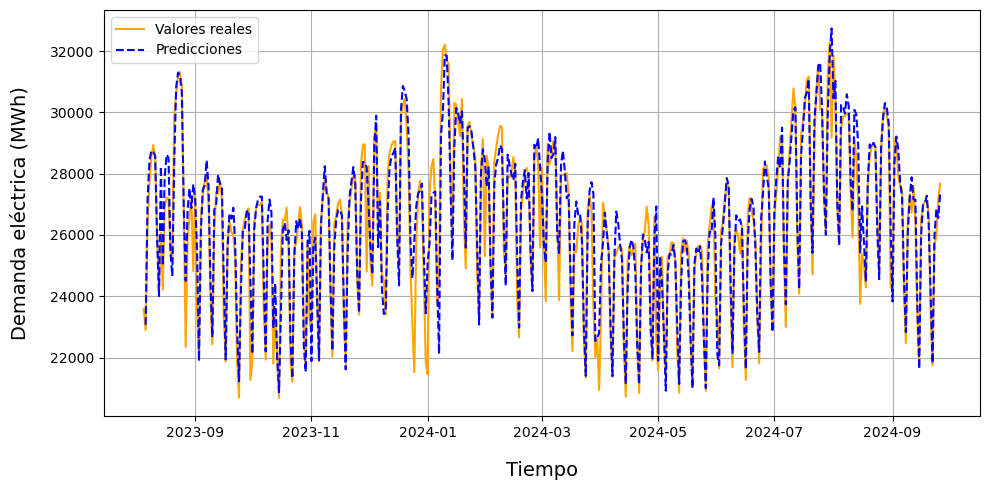

In [ ]:
predictions = resultado[0]

plt.figure(figsize=(10, 5))  # Define el tamaño de la figura
plt.plot(data_test.index, data_test['demanda'], label="Valores reales", color='orange', linestyle='-') # Valores reales
plt.plot(predictions.index, predictions['pred'], label="Predicciones", color='blue', linestyle='--') # Valores predichos

# Configurar el título y las etiquetas
#plt.title("Real Value vs Predicted in Test Data")
plt.xlabel("Tiempo", fontsize=14, labelpad=15)
plt.ylabel('Demanda eléctrica (MW)', labelpad=15, fontsize=14)

# Añadir leyenda
plt.legend(loc='upper left')

# Mostrar el gráfico
plt.grid()  # Añadir cuadrícula para mejor visualización
plt.tight_layout()  # Ajustar el layout
plt.show()